<a href="https://colab.research.google.com/github/yahelrl19/ParkingLotProject/blob/main/ParkingLotProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking Lot Project

Link: https://paperswithcode.com/paper/revising-deep-learning-methods-in-parking-lot

GitHub: https://github.com/eighonet/parking-research

Dataset: https://www.kaggle.com/datasets/braunge/aerial-view-car-detection-for-yolov5/data


TODO:
* Descarga y extracción del dataset
* Visualización de 5 imágenes aleatorias
* Parametros de las imágenes
* Modelo con imágenes del dataset
* Parametros del modelo
* Prueba del modelo con nuevas imágenes
* Modificar el dataset
* Visualizar 5 imágenes aleatorias
* Parametros de las imágenes
* Probar primer modelo con imagenes alteradas
* Modelo con imágenes alteradas
* Probar el anterior dataset con modelo creado de imagenes alteradas
* Comparación de estadísticas

Empezaremos descargando el dataset de Kaggle

In [1]:
!pip install -q torch torchvision matplotlib opencv-python scikit-learn

In [2]:
import os
import requests
import zipfile

# URL del dataset en formato .zip
url = 'https://www.kaggle.com/api/v1/datasets/download/braunge/aerial-view-car-detection-for-yolov5'

# Nombre del archivo .zip a guardar
zip_filename = 'aerial-view-car-detection-for-yolov5.zip'

# Carpeta de destino para las imágenes .jpg
output_folder = 'dataset'
os.makedirs(output_folder, exist_ok=True)

# Descargar el archivo .zip
print(f'Descargando {zip_filename}...')
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(zip_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f'{zip_filename} descargado con éxito.')
else:
    print(f'Error al descargar {zip_filename}: {response.status_code}')
    exit()

# Extraer únicamente archivos .jpg de todas las subcarpetas
print(f'Extrayendo archivos .jpg a la carpeta "{output_folder}"...')
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.lower().endswith('.jpg'):
            # Extraer archivo en la carpeta destino
            zip_ref.extract(file, output_folder)

# Mover los archivos .jpg al nivel raíz de la carpeta output_folder
for root, _, files in os.walk(output_folder):
    for file in files:
        if file.lower().endswith('.jpg'):
            file_path = os.path.join(root, file)
            new_path = os.path.join(output_folder, os.path.basename(file))
            if file_path != new_path:
                os.rename(file_path, new_path)

# Eliminar subcarpetas residuales
for root, dirs, files in os.walk(output_folder, topdown=False):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

# Confirmar los archivos extraídos
extracted_files = [f for f in os.listdir(output_folder) if f.lower().endswith('.jpg')]
print(f'Se han extraído {len(extracted_files)} archivos .jpg a la carpeta "{output_folder}".')
print(f'Primeros archivos extraídos: {extracted_files[:10]}')


Descargando aerial-view-car-detection-for-yolov5.zip...
aerial-view-car-detection-for-yolov5.zip descargado con éxito.
Extrayendo archivos .jpg a la carpeta "dataset"...
Se han extraído 299 archivos .jpg a la carpeta "dataset".
Primeros archivos extraídos: ['6 (28)_1649991778.jpg', '5 (33)_1650425183.jpg', '2 (6)_1649859694.jpg', '1 (50)_1650423524.jpg', '1 (49)_1650423566.jpg', '2 (43)_1650424073.jpg', '4 (12)_1649859974.jpg', '4 (31)_1650425414.jpg', '4 (4)_1649859895.jpg', '4 (38)_1650424439.jpg']


Exploremos el dataset

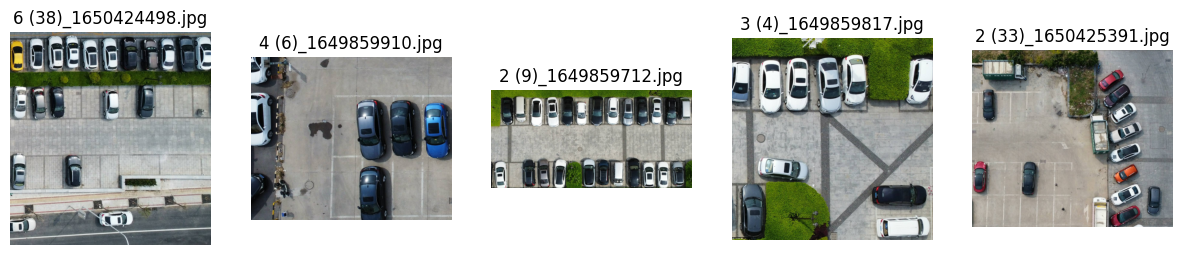

In [3]:
# prompt: Mostrar imagenes aleatorias del dataset descargado

import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta al directorio de imágenes
image_dir = '/content/dataset'

# Obtener una lista de nombres de archivos de imagen
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Mostrar 5 imágenes aleatorias
num_images_to_show = 5
random_image_files = random.sample(image_files, num_images_to_show)

plt.figure(figsize=(15, 10))
for i, image_file in enumerate(random_image_files):
    img_path = os.path.join(image_dir, image_file)
    img = mpimg.imread(img_path)
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')

plt.show()

Preparando el dataset sin modificar para modelo

In [4]:
import os
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Definir un Dataset personalizado
class CustomImageDataset(DatasetFolder):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = read_image(image_path).float() / 255.0  # Normalizar imágenes [0, 1]
        if self.transform:
            image = self.transform(image)
        # Etiqueta genérica: 0 para todas las imágenes
        label = 0
        return image, label

# Crear el conjunto de datos
dataset = CustomImageDataset(image_folder=output_folder, transform=transform)

# Dividir dataset en entrenamiento y validación
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Conjunto de datos cargado exitosamente:")
print(f" - Total imágenes: {len(dataset)}")
print(f" - Imágenes de entrenamiento: {len(train_dataset)}")
print(f" - Imágenes de validación: {len(val_dataset)}")

Conjunto de datos cargado exitosamente:
 - Total imágenes: 299
 - Imágenes de entrenamiento: 239
 - Imágenes de validación: 60
